# Crop Field SimCLR with Graph-based segmentation

This notebook is part of the field boundary detection project. The goal is to evaluate the algorithm using single samples (1D) instead of 2D combining time series of the same h3 hex AND semi-supervised contrastive learning with Graph-based segmentation.

## Summary
[1. Data Processing](#data_processing)

[2. Model Training](#model_training)

[3. Graph Based Segmenation](#graphbased_segmentation)

## Load required libraries

In [1]:
import sys

# Install packages required only once
install_packages = False

if install_packages:
    !{sys.executable} -m pip install sklearn
    !{sys.executable} -m pip install seaborn

In [2]:
import math
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

import folium
import h3

## Hyper-parameters and other constants

In [3]:
temporal_samples = 15
band_features = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

width = 60 # output vector size
temperature = 0.1 # empirical temperature value

steps_per_epoch = 40
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5
num_epochs = 80

queue_size = 10000
kernel_size = 3
strides = 1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"jitter": 0.15}
classification_augmentation = {"jitter": 0.05}

<a id='data_processing'></a>

# 1. Data Processing

<div>
<img border="5px" src="../res/dataprocessing.png" width="1000"/>
</div>

## Configure the train and test datasets

In [4]:
from pathlib import Path

positive_samples_folder = Path('D:\\173_seeding_harvest_joined_USCA_mini.parquet\\positive_samples')
negative_samples_folder = Path('D:\\173_seeding_harvest_joined_USCA_mini.parquet\\negative_samples')

## Load all parquet files from the configured folder

In [5]:
df_positive = pd.concat(
            pd.read_parquet(positive_samples_folder)
            for parquet_file in positive_samples_folder.rglob('*.parquet')
         )

df_negative = pd.concat(
            pd.read_parquet(negative_samples_folder)
            for parquet_file in negative_samples_folder.rglob('*.parquet'))

print('The shape of loaded positive dataframe is:', df_positive.shape)
print('The shape of loaded negative dataframe is:', df_negative.shape)

df_positive = df_positive.drop_duplicates()
df_negative = df_negative.drop_duplicates()

df_positive['timestamp'] = df_positive.scene_id.str[11:26]
df_negative['timestamp'] = df_negative.scene_id.str[11:26]

print('The shape of loaded positive dataframe is:', df_positive.shape)
print('The shape of loaded negative dataframe is:', df_negative.shape)

display(df_positive.head(5))
display(df_negative.head(5))


The shape of loaded positive dataframe is: (3337032, 20)
The shape of loaded negative dataframe is: (2521542, 20)
The shape of loaded positive dataframe is: (98148, 21)
The shape of loaded negative dataframe is: (74163, 21)


start_date                   end_date  \
0  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
1  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
2  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
3  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
4  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   

                              FIELD_OPERATION_GUID  \
0  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
1  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
2  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
3  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
4  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   

                                            scene_id              hex  \
0  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c13ff   
1  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c17ff   
2  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c23ff   
3  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c27ff   
4  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c31ff   

   SCL_val s2_tile    B01    B02     B03  ...     B05     B06     B07     B08  \
0        4   14RPQ  521.0  536.0  1036.0  ...  1486.0  3316.0  3837.0  3984.0   
1        4   14RPQ  521.0  537.0  1036.0  ...  1504.0  3390.0  3843.0  3842.0   
2        4   14RPQ  527.0  565.0   849.0  ...  1390.0  2555.0  2796.0  2536.0   
3        4   14RPQ  556.0  509.0   979.0  ...  1462.0  2922.0  3187.0  3292.0   
4        4   14RPQ  527.0  536.0  1011.0  ...  1512.0  3284.0  3733.0  3654.0   

      B8A     B09     B11     B12     hex_index_L3        timestamp  
0  4040.0  3963.0  2649.0  1518.0  8348b3fffffffff  20181029T170421  
1  4074.0  3963.0  2607.0  1495.0  8348b3fffffffff  20181029T170421  
2  3128.0  3746.0  2583.0  1605.0  8348b3fffffffff  20181029T170421  
3  3500.0  3856.0  2598.0  1540.0  8348b3fffffffff  20181029T170421  
4  3985.0  3746.0  2603.0  1538.0  8348b3fffffffff  20181029T170421  

[5 rows x 21 columns]

start_date                   end_date  \
0  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
1  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
2  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
3  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
4  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   

                              FIELD_OPERATION_GUID  \
0  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
1  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
2  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
3  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
4  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   

                                            scene_id              hex  \
0  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c01ff   
1  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c03ff   
2  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c05ff   
3  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c07ff   
4  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c0bff   

   SCL_val s2_tile    B01     B02     B03  ...     B05     B06     B07  \
0        5   14RPQ  888.0  1034.0  1458.0  ...  1956.0  3277.0  3696.0   
1        4   14RPQ  888.0   934.0  1272.0  ...  1669.0  2765.0  3081.0   
2        4   14RPQ  888.0  1042.0  1458.0  ...  1903.0  3050.0  3344.0   
3        4   14RPQ  888.0   956.0  1256.0  ...  1643.0  2492.0  2738.0   
4        4   14RPQ  760.0   916.0  1368.0  ...  1844.0  3406.0  3768.0   

      B08     B8A     B09     B11     B12     hex_index_L3        timestamp  
0  4004.0  3844.0  3662.0  3317.0  2241.0  8348b3fffffffff  20181029T170421  
1  2800.0  3364.0  3662.0  2883.0  1914.0  8348b3fffffffff  20181029T170421  
2  3124.0  3636.0  3662.0  3379.0  2425.0  8348b3fffffffff  20181029T170421  
3  2832.0  3076.0  3662.0  2916.0  2007.0  8348b3fffffffff  20181029T170421  
4  4232.0  4069.0  3958.0  3155.0  1978.0  8348b3fffffffff  20181029T170421  

[5 rows x 21 columns]

In [6]:
print('In this dataset there are ', df_positive.hex.unique().size, ' different positive hexes')
print('In this dataset there are ', df_negative.hex.unique().size, ' different negative hexes')

positive_l12_hexes = df_positive.hex.unique()
negative_l12_hexes = df_negative.hex.unique()

ambiguous_l12_hexes = set(positive_l12_hexes).intersection(negative_l12_hexes)
print('There are ', len(ambiguous_l12_hexes), ' hexes labeled both as positive and negative')

In this dataset there are  4939  different positive hexes
In this dataset there are  3772  different negative hexes
There are  184  hexes labeled both as positive and negative


In [7]:
df_positive = df_positive[~df_positive['hex'].isin(ambiguous_l12_hexes)]
df_negative = df_negative[~df_negative['hex'].isin(ambiguous_l12_hexes)]

print('In this dataset there are ', df_positive.hex.unique().size, ' different positive hexes')
print('In this dataset there are ', df_negative.hex.unique().size, ' different negative hexes')

In this dataset there are  4755  different positive hexes
In this dataset there are  3588  different negative hexes


In [8]:
temporal_samples_count = df_positive.groupby(['hex'])['hex'].count()

print('There are hexes with temporal samples from : ', min(temporal_samples_count), ' to ', max(temporal_samples_count))

There are hexes with temporal samples from :  16  to  37


## Sentinel 2 bands
These are the 12 bands contained in the parque files and their respective meanings

<div>
<img src="../res/sentinel2-bands.png" width="500"/>
</div>

## Show some of the L12 hexes loaded in the folium map

In [9]:
h3_hex = df_positive.iloc[0]['hex_index_L3']

center = h3.h3_to_geo_boundary(h=h3_hex,geo_json=True)

hexes_to_print=500
df_positive_single_hex = df_positive.drop_duplicates(subset='hex', keep="first").head(hexes_to_print)
df_negative_single_hex = df_negative.drop_duplicates(subset='hex', keep="first").head(hexes_to_print)

m = folium.Map(location=(center[0][1], center[0][0]),
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                zoom_start=17,
                overlay = False,
                control = True)

# Print h3 hex
geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=h3_hex,geo_json=True)]}
geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'white', 'color': 'white', 'weight': 0.5})
geo_j.add_to(m)

# Print positive samples
for index, row in df_positive_single_hex.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'yellow', 'color': 'green', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)
    
# Print negative samples
for index, row in df_negative_single_hex.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'red', 'color': 'black', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)

m

# Visualize the samples in the space reduced to 2 dimensions

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

number_of_bands = len(band_features)

# Keep only [temporal samples] samples 
df_positive = df_positive.sort_values(by=['hex'])
df_positive = df_positive.groupby('hex').head(temporal_samples)

df_negative = df_negative.sort_values(by=['hex'])
df_negative = df_negative.groupby('hex').head(temporal_samples)

# Associate labels picked manually
df_negative = df_negative.assign(label=0)
df_positive = df_positive.assign(label=1)
df = pd.concat([df_positive, df_negative], axis=0)

#df[band_features] = StandardScaler().fit_transform(df[band_features])

display(df[['hex'] + band_features + ['timestamp']].head(5))

# Organize the 2D samples in numpy arrays
sample = np.zeros((temporal_samples, number_of_bands), dtype=np.float64)
X_array = np.empty((0, temporal_samples, number_of_bands),  dtype=np.float64)

labels = []
hexes = []
timestamp_tracking = []
timestamp_sample = []

sub_index = 0
for index, row in df.iterrows():
        # fill the band values in a temporal row
        for idx,b in enumerate(band_features):
            sample[sub_index][idx] = row[b]

        timestamp_sample.append(row.timestamp)
         
        # increment row number 
        sub_index = sub_index + 1
        
        # if reached last row of temporal samples, increment to next sample
        if sub_index == temporal_samples:
            #np.random.shuffle(sample)

            shuffler = np.random.permutation(sample.shape[0])
            sample = sample[shuffler]
            timestamp_sample = list(np.array(timestamp_sample)[shuffler])

            if len(timestamp_sample) != temporal_samples:
                print('Invalid sample!')

            X_array = np.append(X_array, [sample], axis=0)

            labels.append(row.label)
            hexes.append(row.hex)
            timestamp_tracking.append(timestamp_sample.copy())            
            timestamp_sample.clear()
            sub_index = 0

print(X_array.shape)
print(len(labels))
print(len(hexes))

if(False):
    model = TSNE(n_components=2, perplexity=4, random_state=0)
    tsne_data = model.fit_transform(X_array.reshape(X_array.shape[0], number_of_bands * temporal_samples))
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
    tsne_data = pd.concat([tsne_df, pd.DataFrame(labels, columns=['y'])], axis=1)
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "y"))

    sns.jointplot(data=tsne_df, x="Dim_1", y="Dim_2", hue='y')
    plt.show()
    warnings.filterwarnings('default')

hex    B01    B02     B03    B04     B05     B06     B07  \
0      8c48b3c444c13ff  521.0  536.0  1036.0  634.0  1486.0  3316.0  3837.0   
55009  8c48b3c444c13ff  152.0  180.0   178.0  230.0   244.0   258.0   296.0   
80710  8c48b3c444c13ff  847.0  871.0  1102.0  967.0  1670.0  2902.0  3423.0   
50053  8c48b3c444c13ff  370.0  469.0   628.0  859.0   947.0  1162.0  1314.0   
22376  8c48b3c444c13ff  339.0  497.0   808.0  764.0  1350.0  2534.0  2953.0   

          B08     B8A     B09     B11     B12        timestamp  
0      3984.0  4040.0  3963.0  2649.0  1518.0  20181029T170421  
55009   281.0   349.0   279.0   553.0   489.0  20181223T170719  
80710  3538.0  3785.0  3939.0  2965.0  1847.0  20190611T165859  
50053  1238.0  1490.0  1399.0  2155.0  1596.0  20181213T170709  
22376  3222.0  3220.0  3840.0  2728.0  1879.0  20190427T165901

(8342, 15, 12)
8342
8342


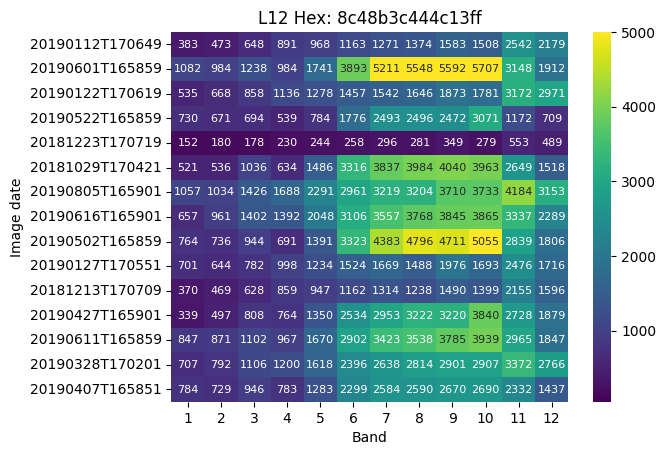

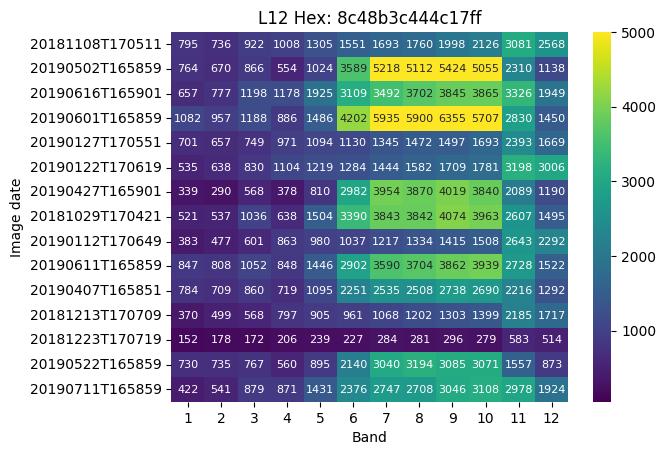

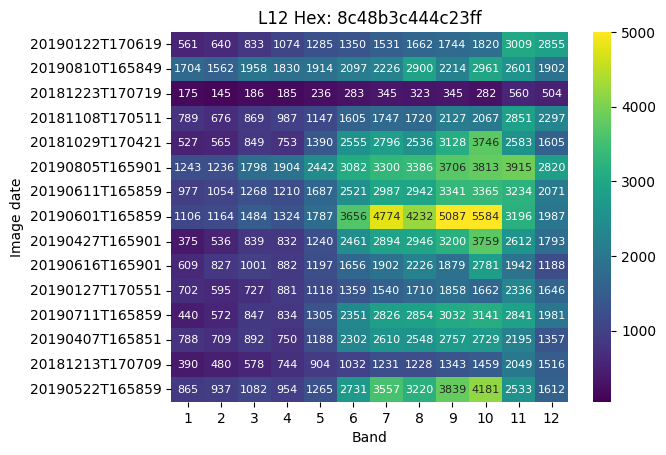

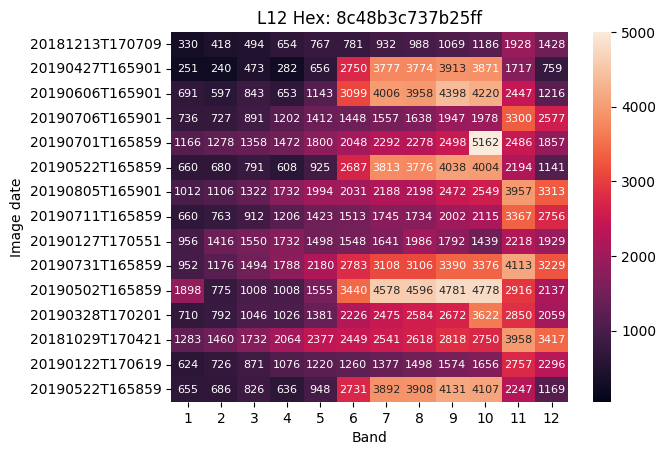

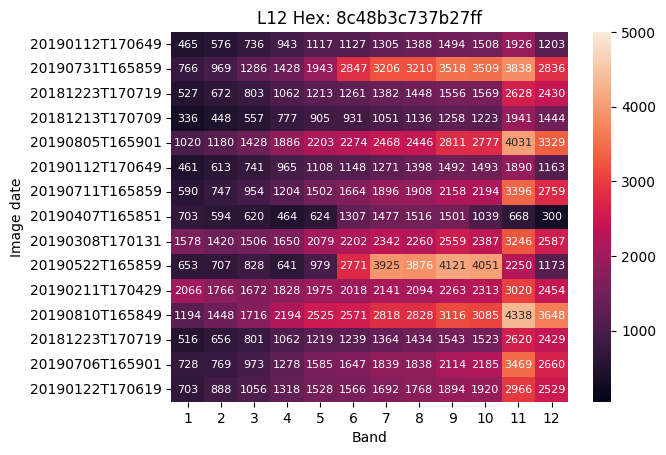

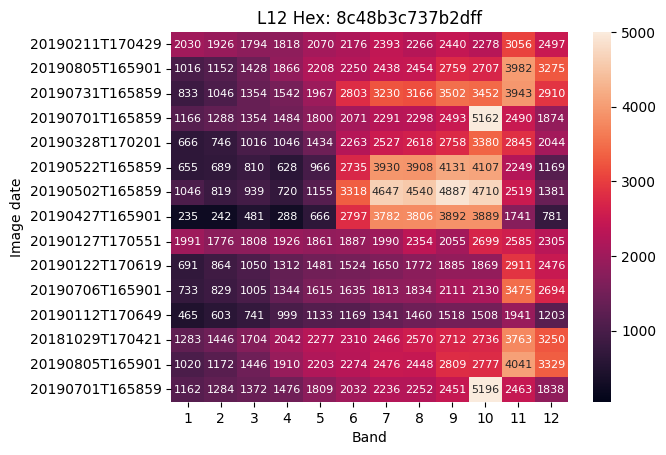

In [11]:
if True:
    for i in range(0,3):
        # This is what a positive sample looks like
        ax = sns.heatmap(X_array[i], annot=True, cmap="viridis", vmin=50, vmax=5000, xticklabels=range(1,13), yticklabels=timestamp_tracking[i], fmt='g', annot_kws={"fontsize":8})
        ax.set(xlabel="Band", ylabel="Image date")
        ax.set(title = 'L12 Hex: ' + hexes[i])
        plt.show()
   

    for i in range(-4,-1):
        # This is what a negative sample looks like
        ax = sns.heatmap(X_array[i], annot=True, cmap="rocket", vmin=50, vmax=5000, xticklabels=range(1,13), yticklabels=timestamp_tracking[i], fmt='g', annot_kws={"fontsize":8})
        ax.set(xlabel="Band", ylabel="Image date")
        ax.set(title = 'L12 Hex: ' + hexes[i])
        plt.show()

<AxesSubplot:xlabel='variable', ylabel='value'>

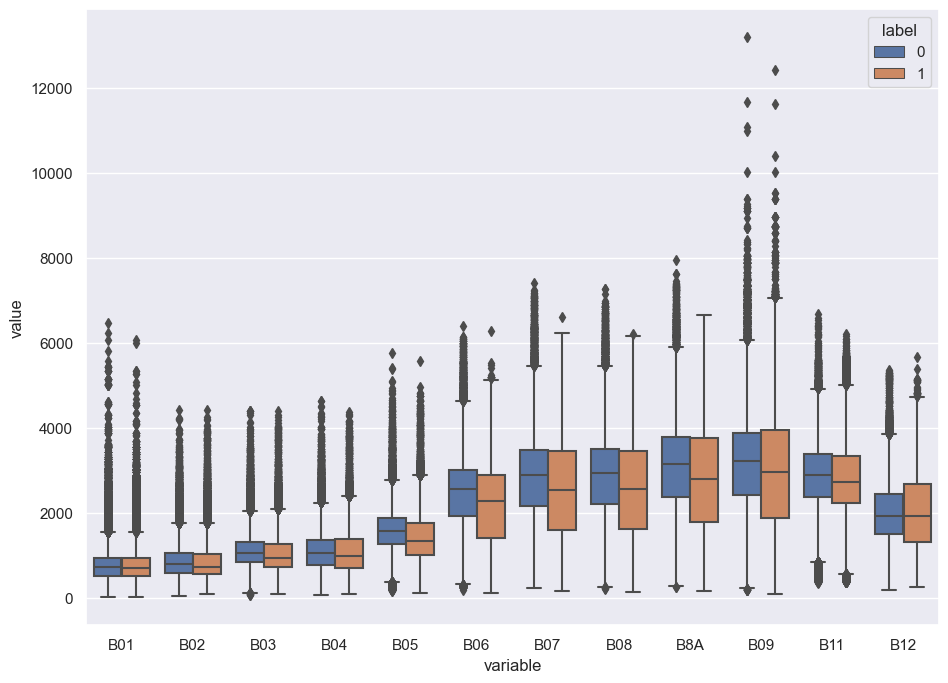

In [12]:
import pandas as pd
import seaborn as sns


value_vars = [i for i in df.columns if i.startswith('B')]
id_vars = ['label']
data = pd.melt(df, id_vars=id_vars, value_vars=value_vars)

sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x="variable", y="value", hue='label', data=data)

# Check correlation among bands

<AxesSubplot:>

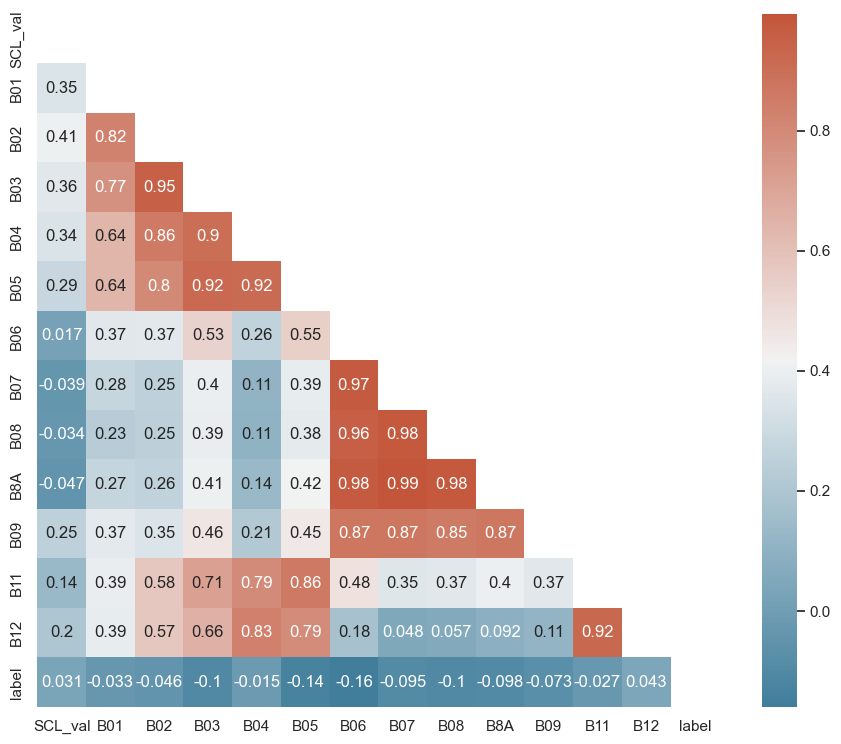

In [13]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

sns.heatmap(corr,mask=mask,cmap=cmap, annot=True )

In [14]:
print(X_array.shape)

(8342, 15, 12)


<AxesSubplot:>

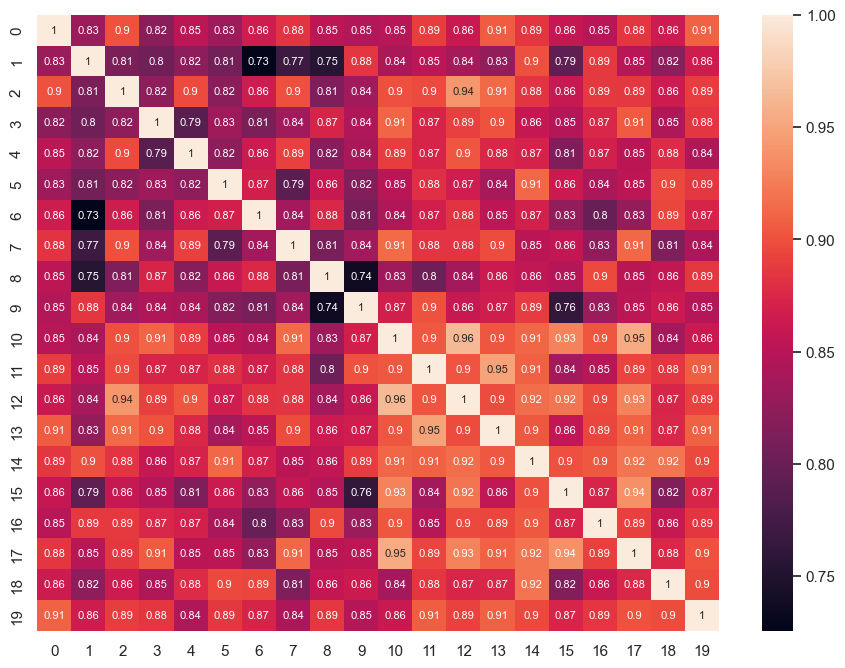

In [15]:
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

number_of_hexes = 10

X_array_positive = X_array[np.array(labels)==1][:number_of_hexes]
X_array_negative = X_array[np.array(labels)==0][:number_of_hexes]
X_array_samples = np.concatenate([X_array_positive, X_array_negative])

similarities = cosine_similarity(X_array_samples.reshape(number_of_hexes * 2, number_of_bands * temporal_samples), X_array_samples.reshape(number_of_hexes * 2,number_of_bands * temporal_samples))

sns.heatmap(similarities, annot=True, annot_kws={"fontsize":8})  

<a id='model_training'></a>

# 2. Contrastive Learning Model Training

<div>
<img border="5px" src="../res/modeltraining.png" width="1000"/>
</div>

## 2.1 Prepare the Dataset

In [16]:
from sklearn.model_selection import train_test_split

print('Total of samples:', X_array.shape)

labels_and_hexes = np.vstack((hexes, labels)).T

# 80% for training, 10% test and 10% validation
X_train, X_test, yl_train, yl_test = train_test_split(X_array, labels_and_hexes, test_size=0.2, random_state=42)
X_val, X_test, yl_val, yl_test = train_test_split(X_test, yl_test, test_size=0.5, random_state=42)

labeled_train_samples = X_train.shape[0]
hexes_train, y_train = np.hsplit(yl_train, 2)
hexes_test, y_test = np.hsplit(yl_test, 2)
hexes_val, y_val = np.hsplit(yl_val, 2)

y_train = [int(y) for y in y_train]
y_test = [int(y) for y in y_test]
y_val = [int(y) for y in y_val]

print('Total of training samples:',X_train.shape, len(y_train))
print('Total of test samples:', X_test.shape, len(y_test))
print('Total of validation samples:', X_val.shape, len(y_val))


Total of samples: (8342, 15, 12)
Total of training samples: (6673, 15, 12) 6673
Total of test samples: (835, 15, 12) 835
Total of validation samples: (834, 15, 12) 834


In [17]:
def prepare_dataset():
    labeled_batch_size = labeled_train_samples // steps_per_epoch
    batch_size = labeled_batch_size
 
    train_dataset = tf.data.Dataset\
        .from_tensor_slices((X_train, y_train))\
        .shuffle(buffer_size=10 * labeled_batch_size)\
        .batch(labeled_batch_size)
    
    test_dataset = tf.data.Dataset\
        .from_tensor_slices((X_test, y_test))\
        .batch(batch_size)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    
    validation_dataset = tf.data.Dataset\
        .from_tensor_slices((X_val, y_val))\
        .batch(5)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)

    return batch_size, train_dataset, test_dataset, validation_dataset

    
    
batch_size, train_dataset, test_dataset, validation_dataset = prepare_dataset()

In [18]:
# Distorts the color distibutions of images
class RandomAugmentSatelliteBands(layers.Layer):
    def __init__(self, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            #jitter_matrices = tf.random.uniform(
            #    (batch_size, temporal_samples, number_of_bands), minval=1 - self.jitter, maxval=1 + self.jitter
            #)
            
            jitter_matrices = tf.random.uniform(
                (batch_size, temporal_samples, 1), minval=1 - self.jitter, maxval=1 + self.jitter
            )
            
            jitter_matrices = tf.concat([jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices,jitter_matrices], axis=2)
            
            images = tf.round(images * jitter_matrices)
            
        return images

# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(temporal_samples, number_of_bands)),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Conv1D(width, kernel_size=kernel_size, strides=strides, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

# Image augmentation module
def get_augmenter(jitter):
    return keras.Sequential(
        [
            keras.Input(shape=(temporal_samples, number_of_bands)),
            RandomAugmentSatelliteBands(jitter),
        ]
    )


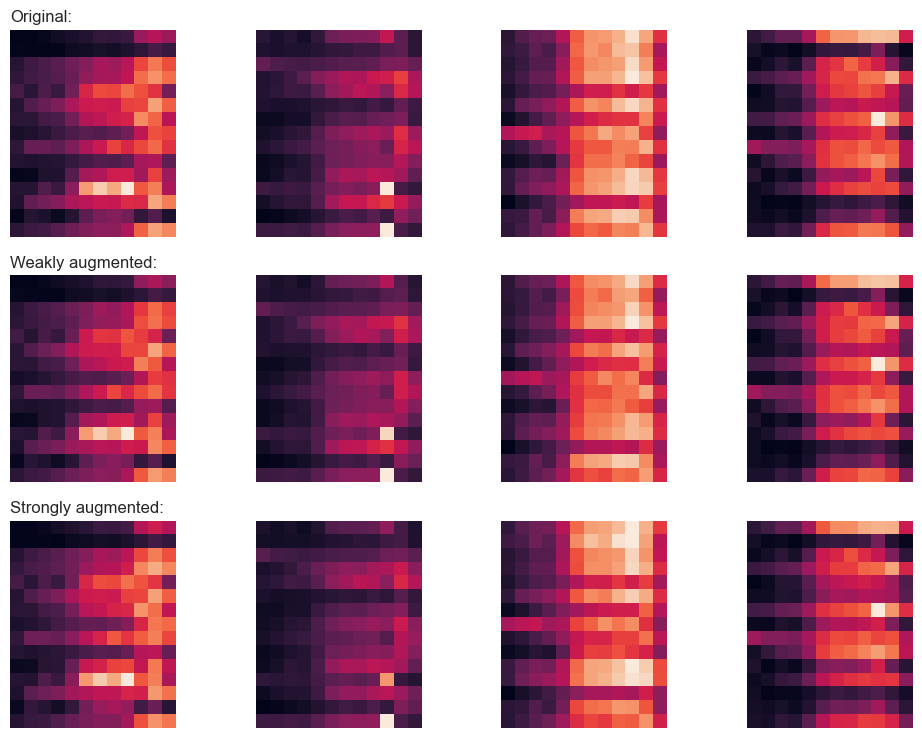

In [19]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][:num_images]
    
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.5, 4 * 2.5), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=4)

In [20]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/80
41/41 [==============================] - 1s 11ms/step - loss: 43.3860 - acc: 0.5606 - val_loss: 4.6636 - val_acc: 0.6251
Epoch 2/80
41/41 [==============================] - 0s 7ms/step - loss: 3.8964 - acc: 0.6642 - val_loss: 2.8414 - val_acc: 0.6778
Epoch 3/80
41/41 [==============================] - 0s 7ms/step - loss: 2.2354 - acc: 0.7105 - val_loss: 2.1487 - val_acc: 0.7018
Epoch 4/80
41/41 [==============================] - 0s 7ms/step - loss: 1.7106 - acc: 0.7220 - val_loss: 1.6875 - val_acc: 0.7042
Epoch 5/80
41/41 [==============================] - 0s 7ms/step - loss: 1.2939 - acc: 0.7439 - val_loss: 1.6330 - val_acc: 0.6970
Epoch 6/80
41/41 [==============================] - 0s 6ms/step - loss: 1.0649 - acc: 0.7617 - val_loss: 1.3556 - val_acc: 0.7341
Epoch 7/80
41/41 [==============================] - 0s 6ms/step - loss: 0.8886 - acc: 0.7680 - val_loss: 1.2316 - val_acc: 0.7401
Epoch 8/80
41/41 [==============================] - 0s 7ms/step - loss: 0.7937 - acc: 0.

41/41 [==============================] - 0s 8ms/step - loss: 0.1045 - acc: 0.9588 - val_loss: 1.0671 - val_acc: 0.7725
Epoch 64/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1105 - acc: 0.9604 - val_loss: 1.1510 - val_acc: 0.7725
Epoch 65/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1321 - acc: 0.9468 - val_loss: 1.1533 - val_acc: 0.7988
Epoch 66/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1044 - acc: 0.9597 - val_loss: 1.1697 - val_acc: 0.7796
Epoch 67/80
41/41 [==============================] - 0s 7ms/step - loss: 0.0915 - acc: 0.9664 - val_loss: 1.1214 - val_acc: 0.7856
Epoch 68/80
41/41 [==============================] - 0s 9ms/step - loss: 0.0850 - acc: 0.9690 - val_loss: 1.1776 - val_acc: 0.7940
Epoch 69/80
41/41 [==============================] - 0s 9ms/step - loss: 0.0868 - acc: 0.9663 - val_loss: 1.1894 - val_acc: 0.7844
Epoch 70/80
41/41 [==============================] - 0s 8ms/step - loss: 0.0839 - acc: 0.9699 -

In [21]:
# Define the contrastive model with model-subclassing

class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()

        
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(1, activation='sigmoid')], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.BinaryCrossentropy(from_logits=False)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.BinaryAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.BinaryAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )        

        # The similarity between the representations of two augmented views of the
        # same hex should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
    
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(contrastive_labels, tf.transpose(similarities))

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.binary_crossentropy(
            contrastive_labels, similarities, from_logits=False
        )
        
        loss_2_1 = keras.losses.binary_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=False
        )
        
        
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = labeled_images
        
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()

pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=True
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)


print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 13, 60)            2220      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 11, 60)            10860     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 9, 60)             10860     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 7, 60)             10860     
_________________________________________________________________
flatten_1 (Flatten)          (None, 420)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                25260     
Total params: 60,060
Trainable params: 60,060
Non-trainable params: 0
_______________________________________________________

41/41 [==============================] - 3s 64ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 5.0251 - p_acc: 0.6581 - val_p_loss: 4.4364 - val_p_acc: 0.6976
Epoch 35/80
41/41 [==============================] - 3s 65ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 5.0241 - p_acc: 0.6594 - val_p_loss: 4.4406 - val_p_acc: 0.7006
Epoch 36/80
41/41 [==============================] - 3s 70ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 4.9604 - p_acc: 0.6613 - val_p_loss: 4.3889 - val_p_acc: 0.7016
Epoch 37/80
41/41 [==============================] - 3s 68ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 4.8719 - p_acc: 0.6656 - val_p_loss: 4.4729 - val_p_acc: 0.6976
Epoch 38/80
41/41 [==============================] - 3s 63ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 4.9516 - p_acc: 0.6614 - val_p_loss: 4.4010 - val_p_acc: 0.6996
Epoch 39/80
41/41 [==============================] - 3s 63ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 4.9977 - p_acc

41/41 [==============================] - 3s 72ms/step - c_loss: -1244.6165 - c_acc: 0.0061 - p_loss: 4.4796 - p_acc: 0.6902 - val_p_loss: 4.0547 - val_p_acc: 0.7257
Maximal validation accuracy: 72.87%


# Encoding a few samples

In [22]:
# Encoder for validation
encoder_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
    ],
    name="encoder_model",
)

encoded_vectors = encoder_model.predict(X_val)

print(encoded_vectors.shape)


(834, 60)


# Visualization of the encoded samples in the XY space

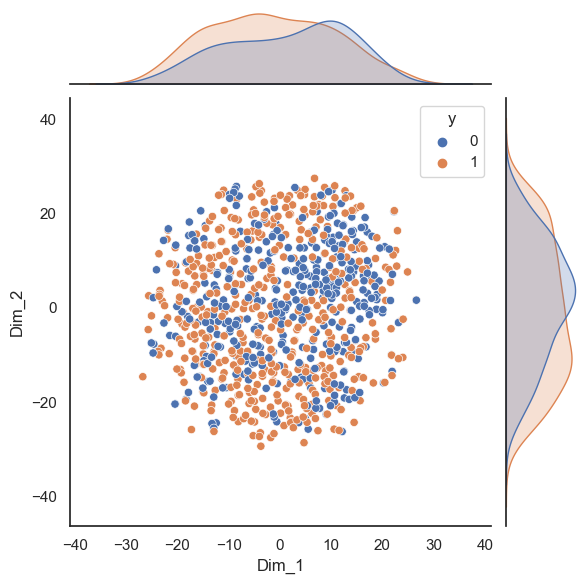

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(encoded_vectors)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))

tsne_df = pd.concat([tsne_df, pd.DataFrame(y_val, columns=['y'])], axis=1)

sns.jointplot(data=tsne_df, x="Dim_1", y="Dim_2", hue='y')
plt.show()
warnings.filterwarnings('default')

# Checking similarities of encoded vectors

<AxesSubplot:>

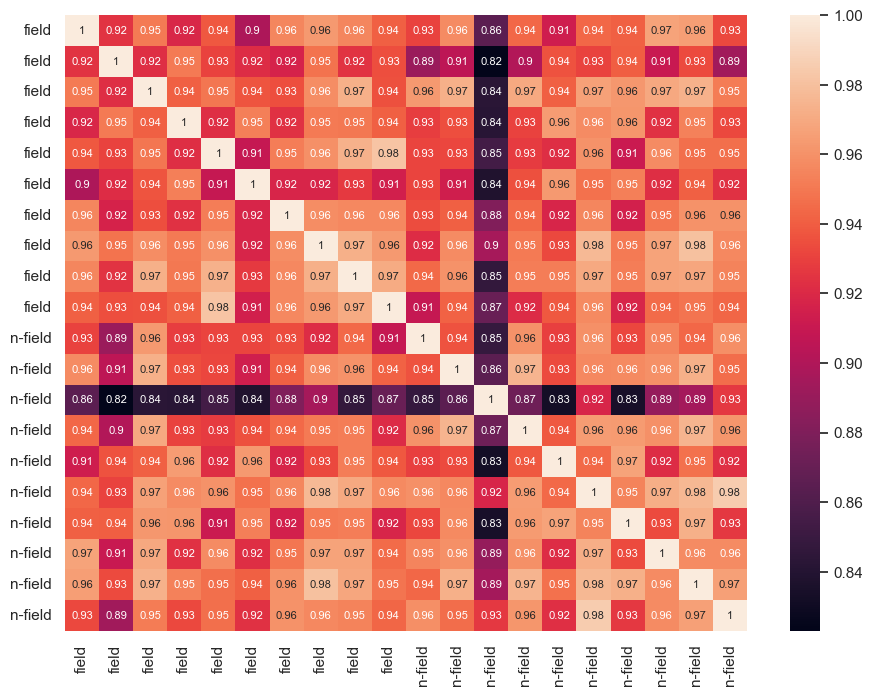

In [24]:
number_of_hexes= 10

df_test = pd.DataFrame(encoded_vectors)
df_test = pd.concat([
                     df_test,
                     pd.DataFrame(y_val, columns=['y'])
                     ], axis=1)

df_sample_five_positive = df_test.loc[df_test['y'] == 1].head(number_of_hexes)
df_sample_five_negative = df_test.loc[df_test['y'] == 0].head(number_of_hexes)
df_subsample = pd.concat([df_sample_five_positive, df_sample_five_negative])
df_labels = np.concatenate((np.repeat('field',number_of_hexes), np.repeat('n-field', number_of_hexes)))

df_subsample_norm = tf.math.l2_normalize(df_subsample, axis=1)
similarities = tf.matmul(df_subsample_norm, df_subsample_norm, transpose_b=True)

sns.heatmap(similarities.numpy(), xticklabels=df_labels, yticklabels=df_labels, annot=True, annot_kws={"fontsize":8} )

## Finetuning model

In [25]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(1, activation='sigmoid'),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)



Epoch 1/80
41/41 [==============================] - 1s 10ms/step - loss: 40.3765 - acc: 0.5614 - val_loss: 6.4706 - val_acc: 0.6491
Epoch 2/80
41/41 [==============================] - 0s 7ms/step - loss: 4.2986 - acc: 0.6847 - val_loss: 3.1594 - val_acc: 0.6922
Epoch 3/80
41/41 [==============================] - 0s 7ms/step - loss: 2.4032 - acc: 0.7415 - val_loss: 2.4526 - val_acc: 0.7317
Epoch 4/80
41/41 [==============================] - 0s 7ms/step - loss: 1.9103 - acc: 0.7536 - val_loss: 3.3197 - val_acc: 0.6647
Epoch 5/80
41/41 [==============================] - 0s 7ms/step - loss: 1.6556 - acc: 0.7593 - val_loss: 1.8198 - val_acc: 0.7365
Epoch 6/80
41/41 [==============================] - 0s 7ms/step - loss: 1.1893 - acc: 0.7817 - val_loss: 1.3296 - val_acc: 0.7629
Epoch 7/80
41/41 [==============================] - 0s 7ms/step - loss: 0.9891 - acc: 0.7995 - val_loss: 1.1951 - val_acc: 0.7760
Epoch 8/80
41/41 [==============================] - 0s 7ms/step - loss: 0.8446 - acc: 0.

41/41 [==============================] - 0s 7ms/step - loss: 0.1207 - acc: 0.9519 - val_loss: 0.9338 - val_acc: 0.8144
Epoch 64/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1724 - acc: 0.9284 - val_loss: 0.8478 - val_acc: 0.8096
Epoch 65/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1426 - acc: 0.9438 - val_loss: 0.9136 - val_acc: 0.7844
Epoch 66/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1385 - acc: 0.9450 - val_loss: 0.8284 - val_acc: 0.7796
Epoch 67/80
41/41 [==============================] - 0s 8ms/step - loss: 0.1110 - acc: 0.9585 - val_loss: 0.8205 - val_acc: 0.8132
Epoch 68/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1091 - acc: 0.9579 - val_loss: 0.7578 - val_acc: 0.8180
Epoch 69/80
41/41 [==============================] - 0s 7ms/step - loss: 0.1105 - acc: 0.9577 - val_loss: 0.7622 - val_acc: 0.8240
Epoch 70/80
41/41 [==============================] - 0s 7ms/step - loss: 0.2003 - acc: 0.9209 -

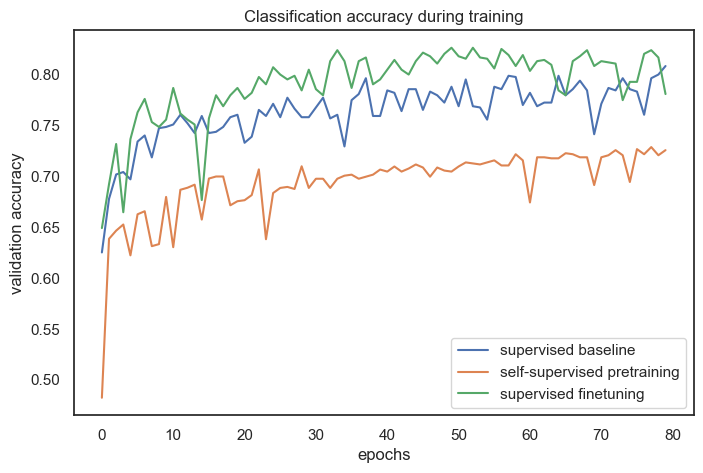

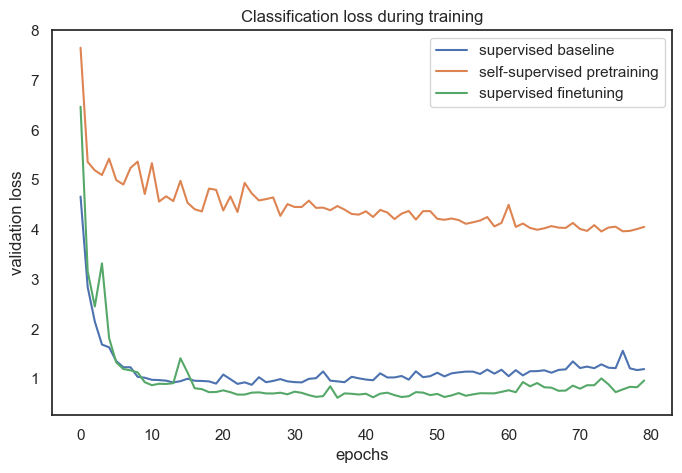

In [26]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

In [27]:
output = finetuning_model.predict(validation_dataset)
result = np.where(output > 0.5, 1, 0)

In [28]:
df_classes = pd.DataFrame(result, columns=['label'])
df_hexes = pd.DataFrame(hexes_val, columns=['hex'])

df_predict = pd.concat([df_hexes,df_classes], axis=1)

center = h3.h3_to_geo_boundary(h=df_predict.iloc[0]['hex'],geo_json=True)

m = folium.Map(location=(center[0][1], center[0][0]),
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True)

for index, row in df_predict.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    
    if row['label'] == 0:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'weight': 0.5})
    elif row['label'] == 1:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'green', 'color': 'green', 'weight': 0.5})  
    else:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'black', 'color': 'black', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)

m

<a id='graphbased_segmentation'></a>

# 3. Graph-based segmentation

<div>
<img border="5px" src="../res/graphbasedsegmentation.png" width="1000"/>
</div>

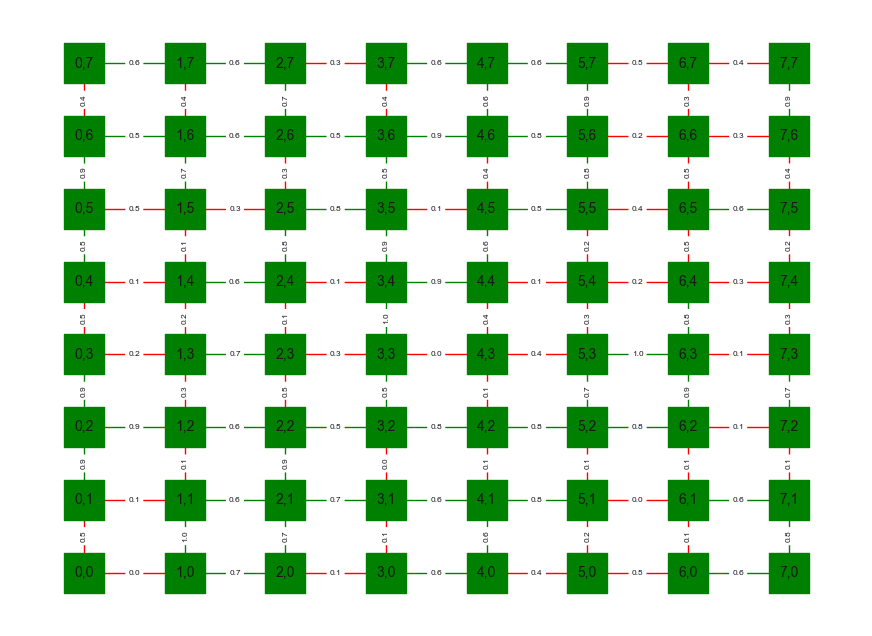

In [215]:
import networkx as nx
import matplotlib.pyplot as plt
import random

N = 8
G=nx.grid_2d_graph(N,N, periodic=False)


edge_colors = []
for a,b in G.edges():
    weight = random.randint(1,100) / 100
    G[a][b]['weight'] = weight
    if weight > 0.5:
        edge_colors.append('green')
    else:
        edge_colors.append('red')


pos = dict( (n, n) for n in G.nodes() )
labels = dict( ((i, j), str(i) + ',' +str(j )) for i, j in G.nodes() )

nx.draw_networkx(G,
                 with_labels=True,
                 pos=pos,
                 font_size=10,
                 labels=labels,
                 node_shape='s',
                 edge_color=edge_colors,
                 node_size=800,
                 node_color="green",
                 style="solid",
                )

labels = nx.get_edge_attributes(G,'weight')


for a,b in labels:
    labels[(a,b)] = round(labels[(a,b)],1)

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=6)
plt.axis('off')
plt.show()

In [216]:
for a,b in G.edges():
    if G[a][b]['weight'] < 0.5:
        G.remove_edge(a,b)

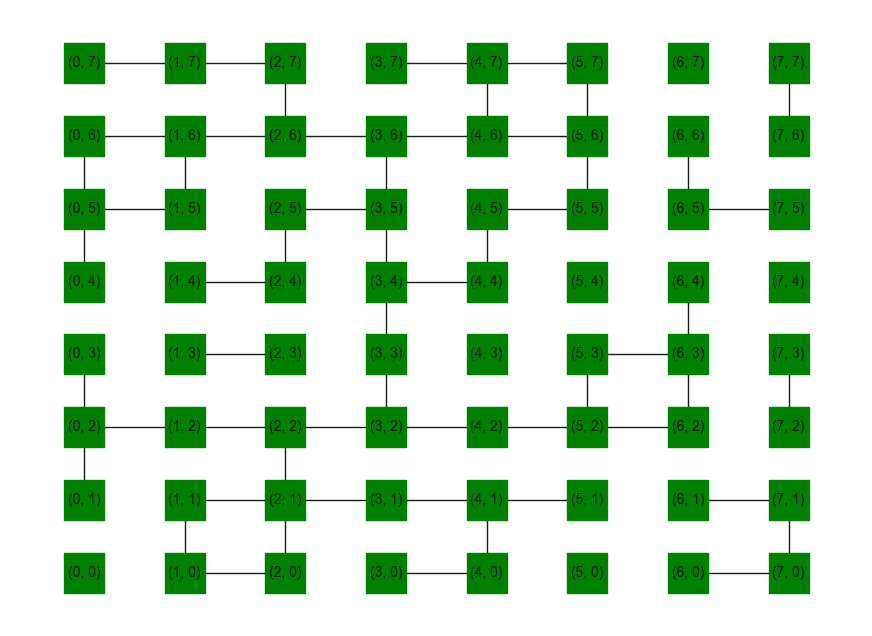

In [217]:
nx.draw_networkx(G,
                 with_labels=True,
                 pos=pos,
                 font_size=10,
                 #labels=labels,
                 node_shape='s',
                 node_size=800,
                 node_color="green",
                 style="solid",
                )

plt.axis('off')
plt.show()

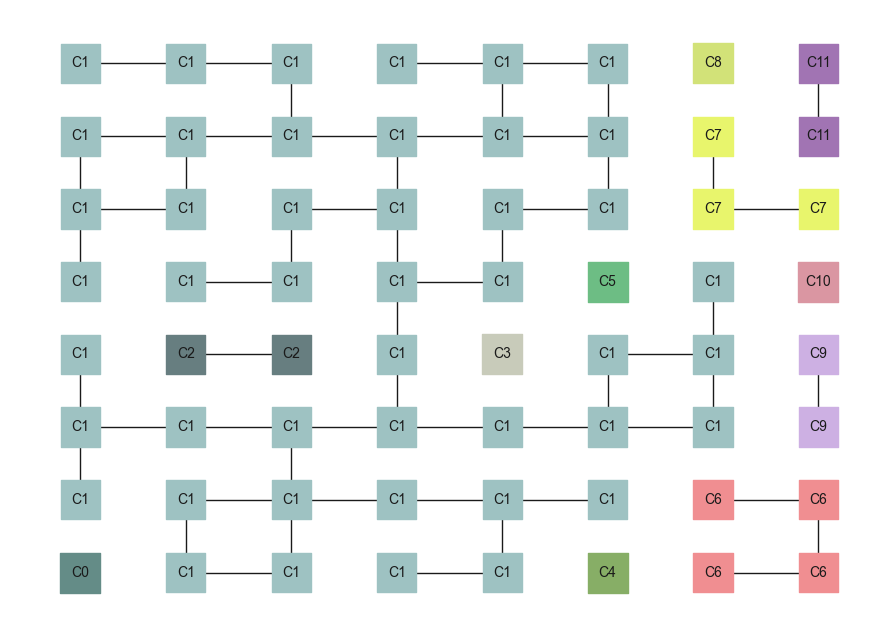

In [218]:
from networkx.algorithms import community

# perform connected component analysis
#components = list(community.greedy_modularity_communities(G))

S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

for idx,H in enumerate(S):
    random_color = list(np.random.choice(range(100,256), size=3)/256)
    cmap = [random_color] * len(H.nodes())
    
    labels = {}
    for n in H.nodes():
        labels[n] = "C" + str(idx)
    
    nx.draw_networkx(H,
                 with_labels=True,
                 pos=pos,
                 font_size=10,
                 labels=labels,
                 node_shape='s',
                 node_size=800,
                 node_color=cmap,
                 style="solid",
                )
plt.axis('off')
plt.show()

# End of Notebook